In [4]:
import xarray as xr
import zarr
import torch
import torch.nn as nn
import torch.optim as optim
from torch import tensor
from torch.utils.data import random_split, Dataset, DataLoader
import pytorch_lightning as pl
from torch.distributed import init_process_group, destroy_process_group
#import mlflow
#import mlflow.pytorch
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar, Callback
import matplotlib.pyplot as plt
import numpy as np
import yaml
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error
from ai_land.data_module import EcDataset, NonLinRegDataModule


def r2_score_multi(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """Calculated the r-squared score between 2 arrays of values

    :param y_pred: predicted array
    :param y_true: "truth" array
    :return: r-squared metric
    """
    return r2_score(y_pred.flatten(), y_true.flatten())


def find_nearest_idx(
    arr1: np.ndarray,
    arr2: np.ndarray,
    val1: float,
    val2: float,
) -> int:
    """Find first nearest index for a given tolerance for two arrays and 2 values

    :param arr1: first array
    :param arr2: second array
    :param val1: value to find in first array
    :param val2: value to find in second array
    :return: index as int
    """
    return (np.abs(arr1 - val1) + np.abs(arr2 - val2)).argmin()


with open("config.yaml") as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

torch.cuda.empty_cache()

In [6]:
%%time
#dataset = EcDataset(path="/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")
dataset = EcDataset(path="/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr/")
clim, met, state, y, y_diag = next(iter(dataset))

CPU times: user 300 ms, sys: 51.8 ms, total: 352 ms
Wall time: 136 ms


In [7]:
%%time
clim, met, state, y, y_diag = next(iter(dataset))

CPU times: user 1.94 s, sys: 11 ms, total: 1.96 s
Wall time: 147 ms


In [4]:
# ds = xr.open_zarr("/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr.zarr")
# ds

In [5]:
# %%time
# idx = find_nearest_idx(ds.lat.values, ds.lon.values, 48, 5)
# print(idx)
# ds2 = ds.sel(time="2011").isel(x=idx).compute()
# ds2

In [6]:
# ds2.sel(variable="t2m", time=slice("2011-01-12", "2011-02-15")).data.plot()

In [8]:
CONFIG

{'clim_feats': ['clim_clake',
  'clim_ldepth',
  'clim_ctype',
  'clim_cell_area',
  'clim_landsea',
  'clim_glm',
  'clim_cu',
  'clim_cvh',
  'clim_cvl',
  'clim_tvh',
  'clim_tvl',
  'clim_sotype',
  'clim_geopot',
  'clim_sdfor',
  'clim_sdor',
  'clim_theta_cap',
  'clim_theta_pwp',
  'clim_veg_covh',
  'clim_veg_covl',
  'clim_veg_z0mh',
  'clim_veg_z0ml',
  'clim_veg_rsminh',
  'clim_veg_rsminl'],
 'dynamic_feats': ['met_ctpf',
  'met_lwdown',
  'met_psurf',
  'met_qair',
  'met_rainf',
  'met_swdown',
  'met_snowf',
  'met_tair',
  'met_wind_e',
  'met_wind_n',
  'lai_hv',
  'lai_lv'],
 'targets_prog': ['swvl1',
  'swvl2',
  'swvl3',
  'stl1',
  'stl2',
  'stl3',
  'snowc',
  'sd'],
 'targets_diag': ['d2m', 't2m', 'skt'],
 'file_path': '/ec/scratch/daep/ecland_i6aj_chunked.zarr',
 'start_year': 2015,
 'end_year': 2020,
 'validation_start': 2021,
 'validation_end': 2021,
 'x_slice_indices': [0, 'None'],
 'roll_out': 8,
 'batch_size': 1000,
 'num_workers': 16,
 'hidden_dim': 192,

In [9]:
# Set device
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [22]:
# Define a neural network model with hidden layers and activation functions
class NonLinearRegression(pl.LightningModule):
    def __init__(self, input_size_clim, input_size_met, input_size_state, hidden_size, output_size, diag_output_size):
        super(NonLinearRegression, self).__init__()
        self.diag_output_size = diag_output_size
        self.layer_clim = nn.Linear(input_size_clim, hidden_size)
        self.relu1 = nn.ReLU()
        self.layer_met = nn.Linear(input_size_met, hidden_size)
        self.relu2 = nn.ReLU()
        self.layer_state = nn.Linear(input_size_state, hidden_size)
        self.relu3 = nn.ReLU()

        self.combine_layer = nn.Linear(hidden_size * 3, hidden_size)
        self.lrelu1 = nn.LeakyReLU()

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.lrelu2 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.lrelu3 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        #self.combine_layer_diag = nn.Linear(hidden_size*3, hidden_size)
        #self.lrelu4 = nn.LeakyReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.lrelu5 = nn.LeakyReLU()
        self.fc5 = nn.Linear(hidden_size, diag_output_size)
        
        # Target list
        # self.targ_lst = CONFIG["targets"]
        ds = zarr.open(CONFIG["file_path"])
        fistdiff_idx = [list(ds["variable"]).index(x) for x in CONFIG["targets_prog"]]
        # self.ds_mu = tensor(xr.open_zarr(path).firstdiff_means.sel(variable=self.targ_lst).values)
        self.ds_std = tensor(ds.firstdiff_stdevs[fistdiff_idx])

#         self.targ_scalar = TorchStandardScalerFeatTens(
#             path="normalise/ec_land_deltax_mean_std.zarr",
#             feat_lst=self.targ_lst,
#             #dev=device,
#         )
#     def transform(self, x):
#         x_norm = (x - self.mean.to(self.device)) / (self.std.to(self.device) + 1e-5)
#         return x_norm

#     def inv_transform(self, x_norm):
#         x = (x_norm * (self.std + 1e-5)) + self.mean
#         return x
        

    def forward(self, clim_feats, met_feats, state_feats):
        out_clim = self.relu1(self.layer_clim(clim_feats))
        out_met = self.relu2(self.layer_met(met_feats))
        out_state = self.relu3(self.layer_state(state_feats))

        combined = torch.cat((out_clim, out_met, out_state), dim=-1)
        combined_out = self.lrelu1(self.combine_layer(combined))

        out = self.lrelu2(self.fc1(combined_out))
        out = self.lrelu3(self.fc2(out))
        out = self.fc3(out)
        
        #out_state_update = self.relu3(self.layer_state(state_feats + out))
        #combined_diag = torch.cat((out_clim, out_met, out_state_update), dim=-1)
        #combined_diag_out = self.lrelu4(self.combine_layer_diag(combined_diag))
        #out_diag = self.lrelu5(self.fc4(combined_diag_out))
        out_diag = self.lrelu5(self.fc4(combined_out))
        out_diag = self.fc5(out_diag)
        return out, out_diag
    
    def predict_step(self, clim_feats, met_feats, state_feats):
        preds = state_feats.clone().to(self.device)
        preds_diag = torch.zeros_like(preds)
        
        for x in range(preds.shape[0] - 1):
            input_tensor = torch.cat((clim_feats.to(self.device), met_feats[x].to(self.device), preds[x]), axis=-1)
            preds_dx, preds_diag = self.forward(input_tensor)
            preds[x + 1] = preds[x] + preds_dx
        return preds

    def MSE_loss(self, logits, labels):
        # criterion = nn.MSELoss()
        criterion = nn.SmoothL1Loss()
        return criterion(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x_clim, x_met, x_state, y, y_diag = train_batch
        logits, logits_diag = self.forward(x_clim, x_met, x_state)
        std = self.ds_std.to(self.device)
        loss = self.MSE_loss(
            logits/std, y/std
        )
        loss_diag = self.MSE_loss(
            logits_diag, y_diag
        )
        self.log(
            "train_loss",
            loss,
        )  # on_step=False, on_epoch=True)
        self.log(
            "train_diag_loss",
            loss_diag,
        )

        if CONFIG["roll_out"] > 1:
            # x_clim_rollout = x_clim.clone()
            # x_met_rollout = x_met.clone()
            x_state_rollout = x_state.clone()
            y_rollout = y.clone()
            y_rollout_diag = y_diag.clone()
            for step in range(CONFIG["roll_out"]):
                # x = [batch_size=8, lookback (7) + rollout (3) = 10, n_feature = 37]
                x0 = x_state_rollout[:, step, :, :].clone()  # select input with lookback.
                y_hat, y_hat_diag = self.forward(x_clim[:, step, :, :], x_met[:, step, :, :], x0)  # prediction at rollout step
                y_rollout_diag[:, step, :, :] = y_hat_diag
                if step < CONFIG["roll_out"] - 1:
                    x_state_rollout[:, step + 1, :, :] = (
                        x_state_rollout[:, step, :, :].clone() + y_hat
                    )  # overwrite x with prediction.
                y_rollout[:, step, :, :] = y_hat  # overwrite y with prediction.
            step_loss = self.MSE_loss(
                y_rollout/std, y/std
            )
            step_loss_diag = self.MSE_loss(
            y_rollout_diag, y_diag
            )
            # step_loss = step_loss / ROLLOUT
            self.log(
                "step_loss",
                step_loss,
            )  # on_step=False, on_epoch=True)
            self.log(
                "step_loss_diag",
                step_loss_diag,
            )  # on_step=False, on_epoch=True)
            loss += step_loss
            loss_diag += step_loss_diag

        return loss + loss_diag

    def validation_step(self, val_batch, batch_idx):
        x_clim, x_met, x_state, y, y_diag = val_batch
        std = self.ds_std.to(self.device)
        logits, logits_diag = self.forward(x_clim, x_met, x_state)
        loss = self.MSE_loss(
            logits/std, y/std
        )
        loss_diag = self.MSE_loss(
            logits_diag, y_diag
        )
        r2 = r2_score_multi(
            (logits/std).cpu(),
            (y/std).cpu(),
        )
        r2_diag = r2_score_multi(
            logits_diag.cpu(),
            y_diag.cpu(),
        )
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_R2", r2, on_step=False, on_epoch=True)
        self.log("val_diag_loss", loss_diag, on_step=False, on_epoch=True)
        self.log("val_diag_R2", r2_diag, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [11]:
from pytorch_lightning.loggers import CSVLogger
from ai_land.model import NonLinearRegression

data_module = NonLinRegDataModule()
# dataset = EcDataset(x_idxs=(31294, 32294))
#dataset = EcDataset(path="/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")
dataset = EcDataset(path="/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr/")

csv_logger = CSVLogger('logs', name='testing')  # Change 'logs' to the directory where you want to save the logs
#wandb_logger = WandbLogger(name='l1_loss',project='testing')
#checkpoint_callback = ModelCheckpoint(monitor='val_r**2', mode='max')

# train
input_dim = len(dataset.dynamic_feat_lst + dataset.static_feat_lst)  # Number of input features
input_clim_dim = len(dataset.static_feat_lst)
input_met_dim = len(dataset.dynamic_feat_lst)
input_state_dim = len(dataset.targ_lst)
output_dim = len(dataset.targ_lst)  # Number of output targets
output_diag_dim = len(dataset.targ_diag_lst)
hidden_dim = CONFIG["hidden_dim"]  # Number of hidden units
model_pyt = NonLinearRegression(input_clim_dim,
                                input_met_dim,
                                input_state_dim,
                                hidden_dim,
                                output_dim,
                                output_diag_dim
                                #device
                               )

In [12]:
clim, met, state, y, y_diag = next(iter(dataset))
model_pyt.forward(clim.clone(), met, state)[0].shape

torch.Size([8, 10051, 8])

In [14]:
%%time
torch.cuda.empty_cache()
torch.set_float32_matmul_precision("high")
 
#mlflow.pytorch.autolog()    
#mlflow.set_experiment(CONFIG["logging"]["project"])
mlf_logger = MLFlowLogger(experiment_name=CONFIG["logging"]["project"], tracking_uri="file:./ml-runs")
#mlf_logger.log_dict(CONFIG, "config.json")

from ai_land.train_callbacks import PlotCallback
#test_ds = EcDataset(start_yr=2022, end_yr=2022, x_idxs=(500, 500+1), path="/ec/res4/hpcperm/daep/ecland_i6aj_o400_2010_2022_6hr_subset.zarr")
#plot_callback = PlotCallback(1, test_ds, device=device, logger=mlf_logger)

# torch.set_float32_matmul_precision('medium')
trainer = pl.Trainer(
    # precision='bf16-mixed',
    #logger=csv_logger,
    logger=mlf_logger,
    #logger=wandb_logger,
    callbacks=[#checkpoint_callback,
               RichProgressBar(),
               #plot_callback
    ],
    # callbacks=[RichProgressBar()],
    max_epochs=50,  # 250,  # 150,  # 100,  # 200,
    # enable_progress_bar = False,
    # log_every_n_steps=490,
    # barebones=True,
    # devices=1, accelerator="gpu"
)

# with mlflow.start_run():
trainer.logger.log_hyperparams(CONFIG)
trainer.fit(model_pyt, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Experiment with name lannd_emulator_6hr_newdb_i6aj_sea not found. Creating it.


KeyError: 'time'

In [12]:
model_pyt.eval()
#v_46
#torch.save(model_pyt.state_dict(), "models/pyt_veg.pt")

NonLinearRegression(
  (layer_clim): Linear(in_features=19, out_features=64, bias=True)
  (relu1): Tanh()
  (layer_met): Linear(in_features=12, out_features=64, bias=True)
  (relu2): Tanh()
  (layer_state): Linear(in_features=7, out_features=64, bias=True)
  (relu3): Tanh()
  (combine_layer): Linear(in_features=192, out_features=64, bias=True)
  (lrelu1): Tanh()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (lrelu2): Tanh()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (lrelu3): Tanh()
  (fc3): Linear(in_features=64, out_features=7, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (lrelu5): Tanh()
  (fc5): Linear(in_features=64, out_features=3, bias=True)
)

# Testing out the trained model

In [13]:
test_ds = EcDataset(start_yr="2018", 
                    end_yr="2022", 
                    #path="/perm/daep/ec_land_db_test/ecland_i6aj_2018_2022_6H.zarr",
                    # x_idxs=(500-4,500+4),
                    # x_idxs=(31794-4,31794+4),
                    x_idxs=(500,501),
                    #roll
                   )
# feats = test_ds.ds_ecland[dataset.dynamic_feat_lst].isel(x=4, time=slice(0,-1)).compute()
# feats_arr2 = np.array(feats.to_array().values.T)

In [14]:
test_ds[0][2].shape

torch.Size([400, 1, 7])

In [15]:
model_pyt.cpu()

NonLinearRegression(
  (layer_clim): Linear(in_features=19, out_features=64, bias=True)
  (relu1): Tanh()
  (layer_met): Linear(in_features=12, out_features=64, bias=True)
  (relu2): Tanh()
  (layer_state): Linear(in_features=7, out_features=64, bias=True)
  (relu3): Tanh()
  (combine_layer): Linear(in_features=192, out_features=64, bias=True)
  (lrelu1): Tanh()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (lrelu2): Tanh()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (lrelu3): Tanh()
  (fc3): Linear(in_features=64, out_features=7, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (lrelu5): Tanh()
  (fc5): Linear(in_features=64, out_features=3, bias=True)
)

In [16]:
len(test_ds)

6778

In [17]:
test_ds.x_size

1

In [18]:
states_arr = torch.zeros(len(test_ds), test_ds.x_size, len(test_ds.targ_lst))
states_diag_arr = torch.zeros(len(test_ds), test_ds.x_size, len(test_ds.targ_diag_lst))

for x in range(len(test_ds)-1):
    static_feats, feats, state, state_inc, state_diag = test_ds[x]
    states_arr[x] = state[0]
    states_diag_arr[x] = state_diag[0]

In [19]:
states_arr.shape

torch.Size([7170, 1, 7])

In [20]:
%%time
# Loop over all times and iteratively apply the ML model to construct a 5-year ML estimate to the ec-land model
#feats_arr3 = dataset.dynamic_feat_scalar.transform(
#    tensor(feats_arr2, dtype=torch.float32))#.reshape(1, -1, 19)  # .to(device)
#static_feats = test_ds.X_static_scaled[0,4,:]
preds = states_arr.clone()
preds_diag = states_diag_arr.clone()
#print(feats_arr3.shape)

for x in range(len(test_ds)-1):
    if x % 1000 == 0:
        print(f"on step {x}...")
    with torch.no_grad():
        static_feats, feats, state, state_inc, state_diag = test_ds[x]
        preds_dx, diags_x = model_pyt(static_feats[0], feats[0], preds[x])
        preds[x+1] = preds[x] + preds_dx
        preds_diag[x] = diags_x
        
# preds = dataset.targ_scalar.inv_transform(preds).cpu().numpy() #.reshape(-1, len(dataset.feat_lst))
# preds_diag = dataset.targ_diag_scalar.inv_transform(preds_diag).cpu().numpy() #.reshape(-1, len(dataset.feat_lst))
#preds = np.clip(preds, 0, None)

on step 0...
on step 1000...
on step 2000...
on step 3000...
on step 4000...
on step 5000...
on step 6000...
on step 7000...
CPU times: user 7.41 s, sys: 4.86 s, total: 12.3 s
Wall time: 23.7 s


In [21]:
preds.shape

torch.Size([7170, 1, 7])

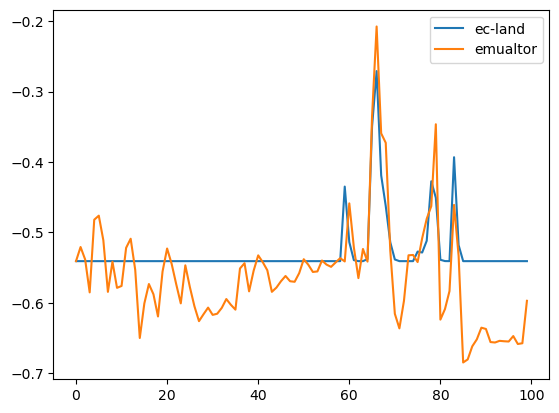

In [22]:
idx = 6

plt.plot(states_arr[:100,0,idx], label="ec-land")
plt.plot(preds[:100,0,idx], label="emualtor")
plt.legend()
plt.show()

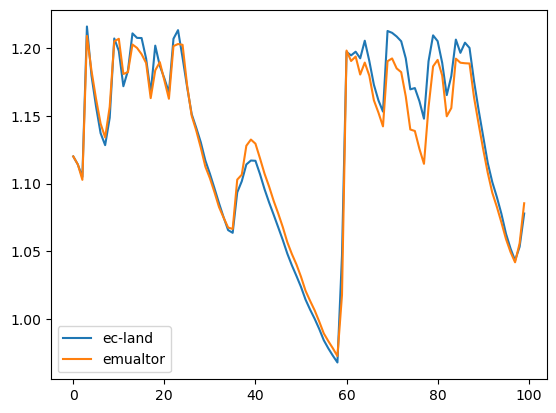

In [23]:
idx = 1

plt.plot(states_arr[:100,0,idx], label="ec-land")
plt.plot(preds[:100,0,idx], label="emualtor")
plt.legend()
plt.show()

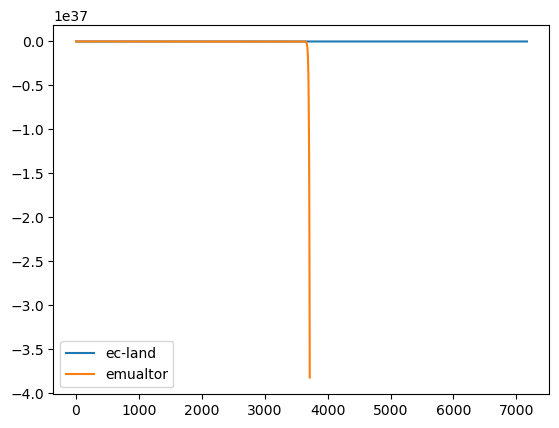

In [24]:
idx = 1
plt.plot(states_arr[:,0,idx], label="ec-land")
plt.plot(preds[:,0,idx], label="emualtor")
plt.legend()
plt.show()

In [ ]:
idx = 7

plt.plot(dataset.targ_scalar.inv_transform(states)[4500:4600,idx], label="ec-land")
plt.plot(preds[4500:4600, idx], '--', label="emualtor")
plt.legend()
plt.show()

In [ ]:
idx = 2

plt.plot(dataset.targ_diag_scalar.inv_transform(states_diag)[4500:4600,idx], label="ec-land")
plt.plot(preds_diag[4500:4600, idx], '--', label="emualtor")
plt.legend()
plt.show()

In [ ]:
idx = 0

plt.plot(dataset.targ_diag_scalar.inv_transform(states_diag)[:,idx], label="ec-land")
plt.plot(preds_diag[:, idx], '--', label="emualtor")
plt.legend()
plt.show()

In [ ]:
model_pyt(static_feats, feats[x], states[x])

In [ ]:
def mod_update(stat_fts, feats, states):
    preds_dx, preds_diag = model_pyt(stat_fts, feats, states)
    # return states+preds_dx, preds_diag
    return torch.cat((states+preds_dx, preds_diag), axis=-1)

In [ ]:
x = 3
jacs = torch.autograd.functional.jacobian(mod_update, (static_feats, feats[x], states[x]))
jacs[2].shape

In [ ]:
fig, ax = plt.subplots()
c = ax.imshow(jacs[2], cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar(c)
ax.set_xticks(np.arange(len(CONFIG["targets_prog"])))
ax.set_xticklabels(CONFIG["targets_prog"])
ax.set_yticks(np.arange(len(CONFIG["targets_prog"]+CONFIG["targets_diag"])))
ax.set_yticklabels(CONFIG["targets_prog"]+CONFIG["targets_diag"])
#ax.set_title(f"Jacobian at {str(dataset.ds_ecland.time.values[x])[:13]} ({dataset.ds_ecland.lat.values[1]:.2f}, {dataset.ds_ecland.lon.values[1]:.2f})")
fig.autofmt_xdate(rotation=45)
plt.show()

In [ ]:
fig, ax = plt.subplots()
c = ax.imshow(jacs[1], cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar(c)
ax.set_xticks(np.arange(len(CONFIG["dynamic_feats"])))
ax.set_xticklabels(CONFIG["dynamic_feats"])
ax.set_yticks(np.arange(len(CONFIG["targets_prog"]+CONFIG["targets_diag"])))
ax.set_yticklabels(CONFIG["targets_prog"]+CONFIG["targets_diag"])
#ax.set_title(f"Jacobian at {str(dataset.ds_ecland.time.values[x])[:13]} ({dataset.ds_ecland.lat.values[1]:.2f}, {dataset.ds_ecland.lon.values[1]:.2f})")
fig.autofmt_xdate(rotation=45)
plt.show()

In [ ]:
fig, ax = plt.subplots()
c = ax.imshow(jacs[0], cmap="RdBu_r", vmin=-0.05, vmax=0.05)
plt.colorbar(c)
ax.set_xticks(np.arange(len(CONFIG["clim_feats"])))
ax.set_xticklabels(CONFIG["clim_feats"])
ax.set_yticks(np.arange(len(CONFIG["targets_prog"]+CONFIG["targets_diag"])))
ax.set_yticklabels(CONFIG["targets_prog"]+CONFIG["targets_diag"])
#ax.set_title(f"Jacobian at {str(dataset.ds_ecland.time.values[x])[:13]} ({dataset.ds_ecland.lat.values[1]:.2f}, {dataset.ds_ecland.lon.values[1]:.2f})")
fig.autofmt_xdate(rotation=45)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(331)
ax2 = plt.subplot(332)
ax3 = plt.subplot(333)
ax4 = plt.subplot(334)
ax5 = plt.subplot(335)
ax6 = plt.subplot(336)
ax7 = plt.subplot(337)

def ailand_plot(var_name, ax, ylabel, ax_title, test_date="2022-01-01"):
    """Plotting function for the ec-land database and ai-land model output

    :param var_name: parameter variable name
    :param ax: the axes to plot on
    :param ylabel: y-label for plot
    :param ax_title: title for plot
    :param test_date: date to plot vertical line (train/test split), defaults to "2022-01-01"
    :return: plot axes
    """
    feats_plt[var_name].plot(label="ec-land", ax=ax)
    ax.plot(feats_plt.time[:], preds[:, dataset.targ_lst.index(var_name)], '--', label="ai-land")
    ax.axvline(feats_plt.sel(time=test_date).time.values[0], color="k", linestyle="--")
    ax.set_xlim(feats_plt.time.values[[0,-1]])
    ax.set_ylabel(ylabel)
    ax.set_title(ax_title)
    return ax

ailand_plot("swvl1", ax1, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 1")
ailand_plot("swvl2", ax2, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 2")
ailand_plot("swvl3", ax3, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 3")
ailand_plot("stl1", ax4, "Soil Temperature (K)", "Soil Temperature Layer 1")
ailand_plot("stl2", ax5, "Soil Temperature (K)", "Soil Temperature Layer 2")
ailand_plot("stl3", ax6, "Soil Temperature (K)", "Soil Temperature Layer 3")
ailand_plot("snowc", ax7, "Snow Cover Fraction (-)", "Snow Cover Fraction")

plt.legend()
fig.suptitle(f"ec/ai-land train-test comparison ({feats_plt.lat.values: .2f} N, {feats_plt.lon.values: .2f} E)")
fig.tight_layout()
plt.show()